In [7]:
import warnings
import json 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay

from jre_utils.config import asset_types
from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.process import get_most_active_municipalities
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [24]:

# only train on top 500 municipalities
dataset_asset_type = "combined"
dataset_key = "transactions"
years_ahead = 3

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "robust": "robust_price_index",
    "ols": "ols_price_index",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "robust"
metric = metrics[metric_key]
metric_sharpe = metric + "_sharpe"
normalized_metric_sharpe = metric_sharpe + "_normalized_yearly"

In [25]:
def drop_invalid_rows(df, column):
    return df[~df[column].isna()].reset_index(drop=True)

In [26]:
id_columns = ["area_code", "area", "year"]

original_factor_columns = [
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_log_normalize_columns = [
    "population",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = []

factor_maintain_columns = [
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
    # + original_factor_columns
)

final_factor_columns = (
    factor_normalize_columns + factor_log_normalize_columns + factor_columns
)

In [45]:
# asset_types_to_train = list(asset_types.keys())
asset_types_to_train = ["building"]
asset_types_as_factors = list(set(asset_types_to_train + ["building"]))

core_log_normalize_columns = []
core_normalize_columns = [metric_sharpe]
core_maintain_columns = ["yearly_price_growth", "metric_sharpe_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

combined_core_columns = [
    f"{asset_type}_{column}"
    for column in core_columns
    for asset_type in asset_types_as_factors
]

In [46]:
feature_columns = factor_columns + combined_core_columns + ["land", "condo"]

In [56]:
start_year = 2006
end_year = 2022
train_start_year = start_year + years_ahead
train_end_year = end_year - years_ahead

all_years = list(range(start_year, end_year + 1))
train_years = list(range(train_start_year, train_end_year + 1))

dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

In [49]:
BATCH_SIZE = 256

In [51]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [52]:
n_features = len(feature_columns)
d_model = 128
d_hid = 128
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0


In [53]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs_per_year = 20

In [57]:
# Incremental training and evaluation
progress_bar = None
save_predictions = True

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

final_train_losses, final_train_r2_scores = {}, {}
final_eval_losses, final_eval_r2_scores = {}, {}

for year in train_years:
    print(f"-----------------")
    print(f" Year: {year}")
    print(f"-----------------")

    df = pd.read_csv(model_ready_data_path)
    df = df.sample(frac=1).reset_index(drop=True)
    df = df.sort_values(by=["year"]).reset_index(drop=True)
    # df = get_most_active_municipalities(df, count_column=f"population", n=500)

    # Weighting by population and elapsed time
    df["log_population"] = df["population"].apply(lambda x: np.log(1 + x))
    
    df["weight"] = df.groupby("year")["log_population"].transform(
        lambda x: x - x.min() + 1
    )

    df["weight"] = df["weight"] * np.where(
        df["year"] <= year, np.exp2(df["year"] - df["year"].min() + 1), 1
    )

    yearly_dataframes = {
        asset_type: {
            f"{year}": drop_invalid_rows(
                df[df["year"] == year], f"{asset_type}_{normalized_metric_sharpe}"
            )
            for year in all_years
        }
        for asset_type in asset_types_to_train
    }

    # Finally
    df = df.fillna(0)

    # Create datasets
    yearly_datasets = {
        asset_type: {
            f"{year}": JapanRETimeSeriesDataset(
                df,
                yearly_dataframes[asset_type][f"{year}"],
                feature_columns=feature_columns,
                metrics=[f"{asset_type}_{normalized_metric_sharpe}"],
                weight_column=f"weight",
                transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
                shift=years_ahead,
            )
            for year in all_years
        }
        for asset_type in asset_types_to_train
    }

    # Compile dataset
    train_dataset = ConcatDataset(
        [
            yearly_datasets[asset_type][f"{train_year}"]
            for train_year in range(start_year, year + 1)
            for asset_type in asset_types_to_train
        ]
    )

    train_dataloader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
    )

    eval_dataset = ConcatDataset(
        [
            yearly_datasets[asset_type][f"{year + years_ahead}"]
            for asset_type in asset_types_to_train
        ]
    )

    eval_dataloader = DataLoader(
        eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
    )

    # Create new model
    model = TimeSeriesTransformerModel(
        n_features=n_features,
        d_model=d_model,
        nhead=nhead,
        d_hid=d_hid,
        nlayers=nlayers,
        dropout=dropout,
        enc_dropout=enc_dropout,
        device=device,
    )
    model = model.to(device)

    # Sanity check
    # num_samples = sum([
    #     yearly_dataframes[asset_type][f"{train_year}"].shape[0]
    #     for train_year in range(start_year, year + 1)
    #     for asset_type in asset_types_to_train
    # ])

    # print(f" Number of training samples: {num_samples}")
    # print(f" Number of training samples: {num_samples}")

    # Prepare training params
    num_training_steps = num_epochs_per_year * len(train_dataloader)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    lr_scheduler = get_scheduler(
        "linear",  # constant
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # Train
    for epoch in range(num_epochs_per_year):
        train_loss, train_r2_score = train_weighted(
            model,
            train_dataloader,
            optimizer,
            lr_scheduler,
            progress_bar,
            device=device,
        )
        train_losses.append(train_loss)
        train_r2_scores.append(train_r2_score)

        eval_loss, eval_r2_score = evaluate_weighted(
            model, eval_dataloader, device=device
        )
        eval_losses.append(eval_loss)
        eval_r2_scores.append(eval_r2_score)

        print(f" Epoch: {epoch}")
        print(f" Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
        print(f" Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

    # Save year end results
    final_train_losses[year] = train_loss
    final_train_r2_scores[year] = train_r2_score
    final_eval_losses[year + years_ahead] = eval_loss
    final_eval_r2_scores[year + years_ahead] = eval_r2_score

    if save_predictions:
        for asset_type in asset_types_to_train:
            # Predict returns for {year + years_ahead} and save for each asset
            output_dataset_name = f"{dataset_name}_{year + years_ahead}"
            model_output_data_path = model_output_data_paths[output_dataset_name]

            prediction_df = yearly_dataframes[asset_type][f"{year + years_ahead}"]

            prediction_df["predicted_normalized_return"] = predict_returns(
                model,
                df,
                prediction_df,
                asset_type,
                feature_columns,
                device=device,
            )

            prediction_df[
                [
                    "year",
                    "area_code",
                    "predicted_normalized_return",
                    f"{asset_type}_yearly_price_growth",
                    f"{asset_type}_{metric_sharpe}",
                    f"{asset_type}_{normalized_metric_sharpe}",
                ]
            ].to_csv(model_output_data_path, index=False)

-----------------
 Year: 2009
-----------------
 Epoch: 0
 Train Loss: 448.5088, Eval Loss: 19.2717
 Train R^2: -0.4668, Eval R^2: -0.1884
 Epoch: 1
 Train Loss: 344.0930, Eval Loss: 16.9757
 Train R^2: -0.1282, Eval R^2: -0.0332
 Epoch: 2
 Train Loss: 299.2695, Eval Loss: 16.6721
 Train R^2: 0.0197, Eval R^2: -0.0064
 Epoch: 3
 Train Loss: 312.5516, Eval Loss: 17.1954
 Train R^2: -0.0076, Eval R^2: -0.0350
 Epoch: 4
 Train Loss: 314.7138, Eval Loss: 17.6036
 Train R^2: -0.0142, Eval R^2: -0.0589
 Epoch: 5
 Train Loss: 332.5365, Eval Loss: 17.6255
 Train R^2: -0.0707, Eval R^2: -0.0602
 Epoch: 6
 Train Loss: 334.5216, Eval Loss: 17.3782
 Train R^2: -0.0747, Eval R^2: -0.0457
 Epoch: 7
 Train Loss: 331.9759, Eval Loss: 17.0565
 Train R^2: -0.0656, Eval R^2: -0.0272
 Epoch: 8
 Train Loss: 306.5447, Eval Loss: 16.7954
 Train R^2: 0.0088, Eval R^2: -0.0127
 Epoch: 9
 Train Loss: 311.0638, Eval Loss: 16.6399
 Train R^2: -0.0114, Eval R^2: -0.0048
 Epoch: 10
 Train Loss: 306.3063, Eval Loss:

In [55]:
{key: round(value, 2) for key, value in final_eval_r2_scores.items()}

{2012: 0.02,
 2013: -0.06,
 2014: -0.03,
 2015: -0.06,
 2016: -0.08,
 2017: -0.06,
 2018: 0.01,
 2019: -0.02,
 2020: 0.03,
 2021: 0.08,
 2022: 0.03}

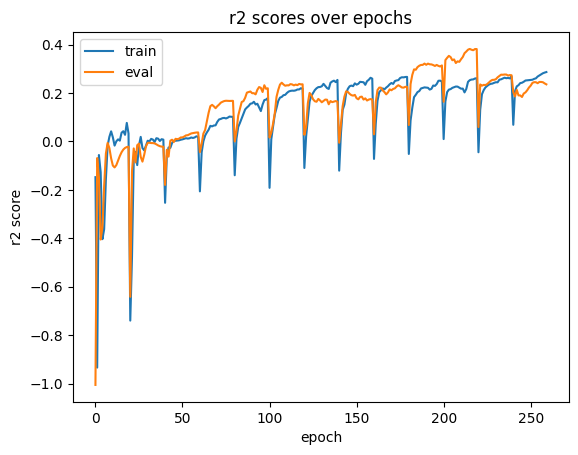

In [70]:
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

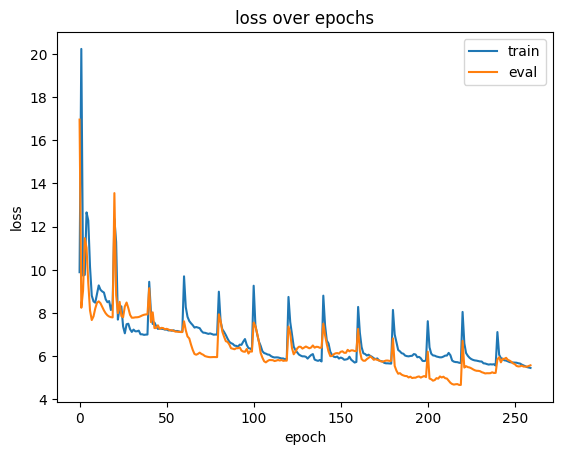

In [71]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()